In [1]:
import os
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray  
from shapely.geometry import shape
from datetime import timedelta
import pystac_client
import odc.stac
from osgeo import gdal

import matplotlib.pyplot as plt

In [8]:
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')
gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL', 'YES')

In [48]:
# --- USER INPUTS (edit here while testing) ---
CLOUD_COVER = 5               # percent max
START_MONTH = 7                # inclusive
STOP_MONTH  = 10               # inclusive
NPAIRS = 5                   # number of pairs per image

aoi = {
    "type": "Polygon",
    "coordinates": [
        [ [-121.76644001937807,46.83837147698088],
            [-121.6594983841296,46.83837147698088],
            [-121.6594983841296,46.8948204721259],
            [-121.76644001937807,46.8948204721259],
            [-121.76644001937807,46.83837147698088]]
    ]
}

# --- pystac-client 0.8.6: open client (no session arg here)
stac = pystac_client.Client.open("https://cmr.earthdata.nasa.gov/stac/LPCLOUD")

In [19]:
search = stac.search(
    collections=["HLSS30.v2.0", "HLSL30.v2.0"],
    intersects=aoi,
    query={"eo:cloud_cover": {"lt": 5}},
    max_items=2000,
)

items = search.item_collection()
print(f"Found {len(items)} HLS items.")

Found 1270 HLS items.


In [20]:
crs_utm = gpd.GeoDataFrame({'geometry':[shape(aoi)]}, crs="EPSG:4326").estimate_utm_crs()

In [21]:
aoi_gpd = gpd.GeoDataFrame({'geometry':[shape(aoi)]}, crs="EPSG:4326")
bbox = aoi_gpd.total_bounds

ds = odc.stac.load(
    items,
    chunks={"x": 2048, "y": 2048},
    bbox=bbox,
    resolution=30,
    crs=crs_utm.to_string(),
    groupby="solar_day"
).where(lambda x: x > 0, other=np.nan)

print(f"Loaded {len(ds.time)} acquisitions.")

Loaded 457 acquisitions.


In [22]:
total_pixels = len(ds.y)*len(ds.x)
nan_count = (~np.isnan(ds.B04)).sum(dim=['x', 'y']).compute()

In [23]:
ds = ds.where(nan_count >= total_pixels*0.9, drop=True)

In [24]:
ds_snowoff = ds.where((ds.time.dt.month >= 7) & (ds.time.dt.month <= 9), drop=True)

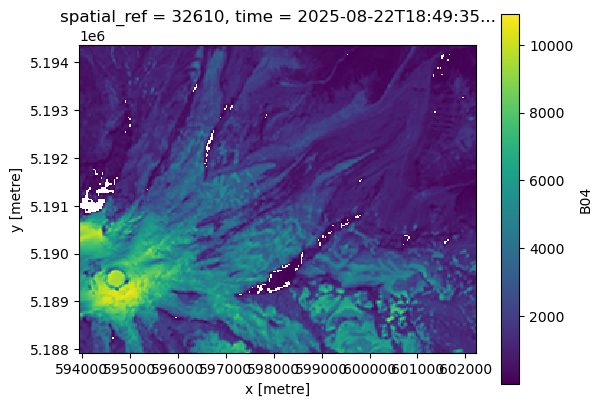

In [36]:
f, ax = plt.subplots()
ds_snowoff.isel(time=96).B04.plot.imshow(ax=ax)
ax.set_aspect('equal')

In [42]:
# get dates of acceptable images
image_dates = ds_snowoff.time.dt.strftime('%Y-%m-%d').values.tolist()
time_vals = ds_snowoff.time.values

In [59]:
pairs = []
min_days = 22
max_days = 100

# For each anchor index i, advance j>i while baseline <= max_days
n = len(time_vals)
for i in range(n - 1):
    ti = np.datetime64(time_vals[i], 'D')
    # start j at i+1 and walk forward until baseline exceeds max_days
    for j in range(i + 1, n):
        tj = np.datetime64(time_vals[j], 'D')
        dt_days = (tj - ti).astype(int)
        if dt_days < min_days:
            continue
        if dt_days > max_days:
            break  # further j will only increase baseline
        # baseline within range
        img1_date = image_dates[i]
        img2_date = image_dates[j]
        shortname = f"{img1_date}_{img2_date}"
        pairs.append({'img1_date': img1_date, 'img2_date': img2_date, 'name': shortname})

print(f"number of image pairs (15–100 d): {len(pairs)}")
# Optional: show a quick preview
if pairs:
    print("\n".join(p['name'] for p in pairs[300:]))
    if len(pairs) > 10:
        print("...")

number of image pairs (15–100 d): 254

...


In [26]:
# --- Build rolling pairs with <= 100 days baseline ---
pairs = []
for r in range(len(ds_snowoff.time) - int(NPAIRS)):
    for s in range(1, int(NPAIRS) + 1):
        t0 = pd.to_datetime(ds_snowoff.isel(time=r).time.values)
        t1 = pd.to_datetime(ds_snowoff.isel(time=r+s).time.values)
        if (t1 - t0).days <= 100:
            img1_date = image_dates[r]
            img2_date = image_dates[r+s]
            shortname = f"{img1_date}_{img2_date}"
            pairs.append({"img1_date": img1_date, "img2_date": img2_date, "name": shortname})

matrixJSON = json.dumps({"include": pairs})
print(f"number of image pairs: {len(pairs)}")

# If you want to emulate writing to GitHub Actions env:
# os.environ['GITHUB_OUTPUT'] must exist in Actions. In a notebook, just show the values:
print("IMAGE_DATES =", image_dates[:10], "…" if len(image_dates) > 10 else "")
print("MATRIX_PARAMS_COMBINATIONS = (json shown below)")
print(matrixJSON[:500] + ("…" if len(matrixJSON) > 500 else ""))

number of image pairs: 223
IMAGE_DATES = ['2013-07-03', '2013-08-13', '2013-08-20', '2013-09-14', '2014-07-06', '2014-07-15', '2015-07-02', '2015-07-18', '2015-08-19', '2015-08-26'] …
MATRIX_PARAMS_COMBINATIONS = (json shown below)
{"include": [{"img1_date": "2013-07-03", "img2_date": "2013-08-13", "name": "2013-07-03_2013-08-13"}, {"img1_date": "2013-07-03", "img2_date": "2013-08-20", "name": "2013-07-03_2013-08-20"}, {"img1_date": "2013-07-03", "img2_date": "2013-09-14", "name": "2013-07-03_2013-09-14"}, {"img1_date": "2013-08-13", "img2_date": "2013-08-20", "name": "2013-08-13_2013-08-20"}, {"img1_date": "2013-08-13", "img2_date": "2013-09-14", "name": "2013-08-13_2013-09-14"}, {"img1_date": "2013-08-20", "img2_date": "…
